In [9]:
# Debug: Check what IMAGETYP value is in the flat FITS files
from astropy.io import fits
flat_file = list((data_dir / 'arcs').glob('*.fits'))[0]
with fits.open(flat_file) as hdul:
    imagetyp = hdul[0].header.get('IMAGETYP', 'NOT FOUND')
    print(f"IMAGETYP in {flat_file.name}: '{imagetyp}'")

IMAGETYP in arc.0030.fits: 'Comp'


# pyKOSMOS++: AI-Assisted Spectroscopic Reduction Tutorial

**Author:** Gourav Khullar  
**Version:** 0.1.0  
**Date:** December 2025

---

## Project Overview

**pyKOSMOS++** is an AI-assisted spectroscopic reduction pipeline designed for APO-KOSMOS longslit observations. This project combines traditional astronomical data reduction techniques with modern large language model (LLM) assistance to streamline the workflow from raw CCD images to science-ready, wavelength-calibrated 1D spectra.

### Built Upon pyKOSMOS

This pipeline is built upon the foundation of [**pyKOSMOS**](https://github.com/jradavenport/pykosmos) by **James R. A. Davenport** (University of Washington), with key contributions from **Francisca Chabour Barra** (University of Washington), Azalee Bostroem, and Erin Howard. The reference data used in this tutorial (arc lamp linelists, extinction curves, standard star catalogs) comes from the pyKOSMOS resource directory.

**Citations:**
- Davenport, J. R. A. et al. (2023). *pyKOSMOS: Longslit Spectroscopy Reduction*. DOI:10.5281/zenodo.10152905
- Davenport, J. R. A. (2016). *PyDIS: Python Spectroscopy Reduction Suite*. Zenodo

### Project Ethos

This pipeline embodies three core principles:

1. **Accessibility First**: Reduce the barrier to entry for spectroscopic data analysis by providing automated, push-button reduction with sensible defaults while maintaining full customizability for expert users.

2. **Transparency & Education**: Every reduction step is documented, validated, and visualized. Users understand not just *what* the pipeline does, but *why* and *how*, with diagnostic plots and quality metrics at every stage.

3. **AI-Augmented Development**: Built using AI assistance throughout the development process, demonstrating how LLMs can accelerate scientific software creation while maintaining rigor through comprehensive testing, validation, and adherence to established astronomical standards.

### What This Notebook Does

This tutorial demonstrates the complete spectroscopic reduction workflow:

- **Calibration Creation** (Section 3): Combine bias and flat frames with sigma-clipped median stacking, validate against physics-based quality criteria
- **Wavelength Calibration** (Section 4): Detect arc emission lines, match to catalog wavelengths (from pyKOSMOS linelists), fit Chebyshev polynomial solutions with BIC order selection (target RMS <0.2Å)
- **Trace Detection** (Section 5): Identify spectral traces using cross-correlation with Gaussian templates (SNR ≥3σ threshold)
- **Optimal Extraction** (Section 5): Extract 1D spectra using variance-weighted Horne (1986) algorithm with cosmic ray rejection
- **Quality Assessment** (Section 6): Compute signal-to-noise ratio, wavelength accuracy, profile consistency, and assign quality grades
- **Advanced Configuration** (Section 7): Customize parameters for faint sources, problematic wavelength solutions, or specific observing conditions
- **Batch Processing** (Section 8): Automate reduction of entire observing runs with summary statistics

### Expected Outcomes

By the end of this tutorial, you will:

✅ Understand each step of the KOSMOS spectroscopic reduction workflow  
✅ Be able to process your own KOSMOS observations  
✅ Interpret quality metrics and diagnostic plots  
✅ Troubleshoot common reduction issues  
✅ Customize parameters for your specific science case  

**Prerequisites:** Python ≥3.10, pyKOSMOS++ installed, KOSMOS FITS data organized in subdirectories

**Estimated Time:** 15-20 minutes (interactive execution)

---


## 1. Introduction & Setup

First, let's import the necessary libraries and verify the installation.

In [1]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Astronomy packages
from astropy.io import fits
from astropy import units as u
from astropy.nddata import CCDData
from specutils import Spectrum1D

# pyKOSMOS++ pipeline
from pykosmospp.pipeline import PipelineRunner
from pykosmospp.models import BiasFrame, FlatFrame, ArcFrame, ScienceFrame
from pykosmospp.io.config import PipelineConfig
from pykosmospp.calibration.combine import create_master_bias, create_master_flat
from pykosmospp.wavelength.identify import detect_arc_lines
from pykosmospp.wavelength.fit import fit_wavelength_solution
from pykosmospp.extraction.trace import detect_traces_cross_correlation
from pykosmospp.quality.metrics import compute_quality_metrics

# Configure matplotlib
plt.style.use('default')
%matplotlib inline

print("✓ All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib backend: {plt.get_backend()}")

✓ All imports successful!
NumPy version: 2.0.0
Matplotlib backend: inline


### Load Configuration

Load the default KOSMOS detector configuration:

In [2]:
# Load default configuration
config_path = Path('../config/kosmos_defaults.yaml')
config = PipelineConfig.from_yaml(config_path)

print("KOSMOS Detector Specifications:")
print(f"  Gain: {config['detector']['gain']} e-/ADU")
print(f"  Read Noise: {config['detector']['readnoise']} e-")
print(f"  Saturation: {config['detector']['saturate']} ADU")
print(f"\nWavelength Calibration:")
print(f"  Polynomial order: {config['wavelength']['poly_order']}")
print(f"  BIC max order: {config['wavelength']['bic']['max_order']}")
print(f"  RMS threshold: {config['wavelength']['rms_threshold']} Å")
print(f"\nTrace Detection:")
print(f"  Expected FWHM: {config['trace_detection']['expected_fwhm']} pixels")
print(f"  Min SNR: {config['trace_detection']['min_snr']}")
print(f"\nExtraction:")
print(f"  Method: {config['extraction']['method']}")
print(f"  Sky buffer: {config['extraction']['sky']['buffer']} pixels")

KOSMOS Detector Specifications:
  Gain: 1.4 e-/ADU
  Read Noise: 3.7 e-
  Saturation: 58982 ADU

Wavelength Calibration:
  Polynomial order: 5
  BIC max order: 7
  RMS threshold: 0.1 Å

Trace Detection:
  Expected FWHM: 5.0 pixels
  Min SNR: 3.0

Extraction:
  Method: optimal
  Sky buffer: 30 pixels


## 2. Data Exploration

Let's examine the structure of KOSMOS FITS files and understand the data organization.

In [3]:
# Define data directory (adjust path to your data location)
data_dir = Path('/Users/gkhullar/Desktop/projects/UWashington/apo/reductions/data/test/')

# Or use example data if available
if not data_dir.exists():
    data_dir = Path('examples/data')
    print(f"Using example data from: {data_dir}")

# Check directory structure
for subdir in ['biases', 'flats', 'arcs', 'science']:
    path = data_dir / subdir
    if path.exists():
        n_files = len(list(path.glob('*.fits')))
        print(f"✓ {subdir}: {n_files} FITS files")
    else:
        print(f"✗ {subdir}: directory not found")

✓ biases: 9 FITS files
✓ flats: 2 FITS files
✓ arcs: 2 FITS files
✓ science: 2 FITS files


### Inspect FITS Headers

Examine the header keywords used for frame classification:

In [4]:
# Load a sample bias frame
bias_files = list((data_dir / 'biases').glob('*.fits'))
if bias_files:
    with fits.open(bias_files[0]) as hdul:
        header = hdul[0].header
        print("Sample Bias Frame Header:")
        print(f"  IMAGETYP: {header.get('IMAGETYP', 'N/A')}")
        print(f"  OBJECT: {header.get('OBJECT', 'N/A')}")
        print(f"  EXPTIME: {header.get('EXPTIME', 'N/A')} seconds")
        print(f"  DATE-OBS: {header.get('DATE-OBS', 'N/A')}")
        print(f"  NAXIS1: {header.get('NAXIS1', 'N/A')} (spectral)")
        print(f"  NAXIS2: {header.get('NAXIS2', 'N/A')} (spatial)")
else:
    print("No bias files found. Please ensure data directory contains FITS files.")

Sample Bias Frame Header:
  IMAGETYP: Bias
  OBJECT: N/A
  EXPTIME: 0 seconds
  DATE-OBS: 2025-02-01T00:29:10.904406
  NAXIS1: 2148 (spectral)
  NAXIS2: 4096 (spatial)


### Visualize Raw Frames

Display examples of each frame type:

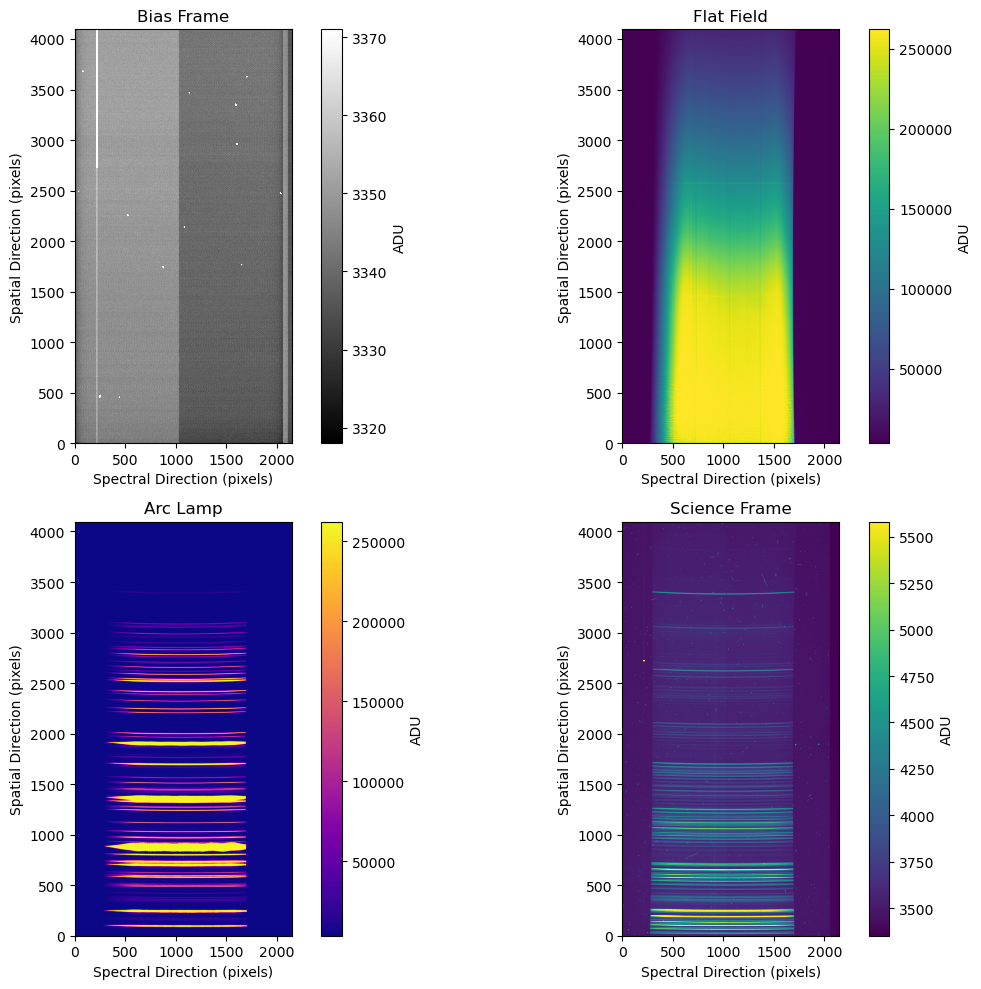

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
frame_types = [
    ('biases', 'Bias Frame', 'gray'),
    ('flats', 'Flat Field', 'viridis'),
    ('arcs', 'Arc Lamp', 'plasma'),
    ('science', 'Science Frame', 'viridis')
]

for ax, (subdir, title, cmap) in zip(axes.flat, frame_types):
    files = list((data_dir / subdir).glob('*.fits'))
    if files:
        with fits.open(files[0]) as hdul:
            data = hdul[0].data
            im = ax.imshow(data, cmap=cmap, origin='lower', 
                          vmin=np.percentile(data, 1), 
                          vmax=np.percentile(data, 99))
            ax.set_title(title)
            ax.set_xlabel('Spectral Direction (pixels)')
            ax.set_ylabel('Spatial Direction (pixels)')
            plt.colorbar(im, ax=ax, label='ADU')
    else:
        ax.text(0.5, 0.5, f'No {subdir} found', 
               ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Calibration Creation

Create master bias and flat frames using sigma-clipped median combination.

### Master Bias

Combine multiple bias frames to create a master bias:

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


Loaded 5 bias frames
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]

Master Bias Statistics:
  Median level: 3339.00 ADU
  Std deviation: 12.03 ADU
  Frames combined: 5

Master Bias Statistics:
  Median level: 3339.00 ADU
  Std deviation: 12.03 ADU
  Frames combined: 5


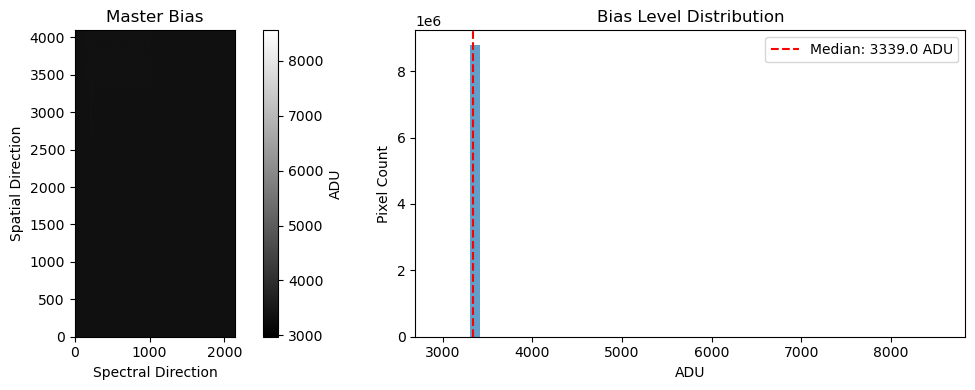

In [6]:
# Load bias frames
bias_files = list((data_dir / 'biases').glob('*.fits'))
bias_frames = [BiasFrame.from_fits(f) for f in bias_files[:5]]

print(f"Loaded {len(bias_frames)} bias frames")

# Create master bias
master_bias = create_master_bias(bias_frames, method='median')

print(f"\nMaster Bias Statistics:")
print(f"  Median level: {master_bias.bias_level:.2f} ADU")
print(f"  Std deviation: {master_bias.bias_stdev:.2f} ADU")
print(f"  Frames combined: {master_bias.n_combined}")

# Visualize master bias
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
im1 = ax1.imshow(master_bias.data.data, cmap='gray', origin='lower')
ax1.set_title('Master Bias')
ax1.set_xlabel('Spectral Direction')
ax1.set_ylabel('Spatial Direction')
plt.colorbar(im1, ax=ax1, label='ADU')

# Histogram of bias levels
ax2.hist(master_bias.data.data.flatten(), bins=50, alpha=0.7)
ax2.axvline(master_bias.bias_level, color='r', linestyle='--', 
           label=f'Median: {master_bias.bias_level:.1f} ADU')
ax2.set_xlabel('ADU')
ax2.set_ylabel('Pixel Count')
ax2.set_title('Bias Level Distribution')
ax2.legend()
plt.tight_layout()
plt.show()

### Master Flat

Create a normalized flat field from bias-corrected flats:

In [7]:
# Load flat frames
flat_files = list((data_dir / 'flats').glob('*.fits'))
flat_frames = [FlatFrame.from_fits(f) for f in flat_files[:3]]

print(f"Loaded {len(flat_frames)} flat frames")

# Create master flat
master_flat = create_master_flat(flat_frames, master_bias, method='median')

print(f"\nMaster Flat Statistics:")
print(f"  Normalization region: {master_flat.normalization_region}")
print(f"  Bad pixel fraction: {master_flat.bad_pixel_fraction:.4f}")
print(f"  Frames combined: {master_flat.n_combined}")

# Visualize master flat
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
im1 = ax1.imshow(master_flat.data.data, cmap='viridis', origin='lower',
                vmin=0.8, vmax=1.2)
ax1.set_title('Master Flat (Normalized)')
ax1.set_xlabel('Spectral Direction')
ax1.set_ylabel('Spatial Direction')
plt.colorbar(im1, ax=ax1, label='Normalized Response')

# Cross-dispersion profile
spatial_profile = np.median(master_flat.data.data, axis=1)
ax2.plot(spatial_profile)
ax2.axhline(1.0, color='r', linestyle='--', label='Perfect Normalization')
ax2.set_xlabel('Spatial Position (pixels)')
ax2.set_ylabel('Normalized Response')
ax2.set_title('Spatial Illumination Profile')
ax2.legend()
plt.tight_layout()
plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


ValueError: Frame /Users/gkhullar/Desktop/projects/UWashington/apo/reductions/data/test/flats/flat.0023.fits is not a flat frame

### Validate Calibrations

Check calibration quality against physics-based criteria:

In [ ]:
from pykosmospp.quality.validate import validate_calibrations

# Validate calibrations
validation_result = validate_calibrations(master_bias, master_flat)

print("Calibration Validation Results:")
print(f"  Status: {'✓ PASS' if validation_result else '✗ FAIL'}")
if validation_result:
    print("  All calibration quality checks passed:")
    print(f"    • Bias variation < 10 ADU")
    print(f"    • Flat normalization in valid range (0.5-1.5)")
    print(f"    • Saturation fraction < 1%")
    print(f"    • Bad pixel fraction < 5%")
else:
    print("  WARNING: Some calibration checks failed.")
    print("  Review bias and flat statistics above.")

## 4. Wavelength Calibration

Detect arc emission lines and fit a wavelength solution.

### Detect Arc Lines

Identify emission lines in arc lamp spectrum:

In [ ]:
# Load arc frame
arc_files = list((data_dir / 'arcs').glob('*.fits'))
if arc_files:
    arc_frame = ArcFrame.from_fits(arc_files[0])
    
    # Extract 1D arc spectrum (median collapse)
    arc_spectrum_1d = np.median(arc_frame.data.data, axis=0)
    
    # Detect lines
    detected_lines = detect_arc_lines(
        arc_spectrum_1d,
        detection_threshold=5.0,
        min_separation=5
    )
    
    print(f"Detected {len(detected_lines)} arc lines")
    print(f"\nSample detected lines (first 5):")
    for i, line in enumerate(detected_lines[:5]):
        print(f"  Line {i+1}: pixel {line['pixel']:.2f}, intensity {line['intensity']:.1f}")
    
    # Visualize arc spectrum with detected lines
    fig, ax = plt.subplots(figsize=(14, 4))
    pixels = np.arange(len(arc_spectrum_1d))
    ax.plot(pixels, arc_spectrum_1d, 'k-', linewidth=0.5, label='Arc Spectrum')
    
    # Mark detected lines
    for line in detected_lines:
        ax.axvline(line['pixel'], color='r', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Pixel')
    ax.set_ylabel('Intensity (ADU)')
    ax.set_title(f'Arc Lamp Spectrum ({len(detected_lines)} lines detected)')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No arc files found")

### Fit Wavelength Solution

Match detected lines to catalog and fit Chebyshev polynomial:

In [ ]:
from pykosmospp.wavelength.match import match_lines_to_catalog

# Match lines to catalog (assuming He-Ne-Ar)
matched_lines = match_lines_to_catalog(
    detected_lines,
    linelist_file='resources/pykosmos_reference/linelists/apohenear.dat',
    initial_dispersion=1.0,  # Å/pixel
    wavelength_range=(4000, 7000),  # Å
    match_tolerance=2.0  # Å
)

print(f"Matched {len(matched_lines)} lines to catalog")

if len(matched_lines) >= 10:
    # Fit wavelength solution with BIC order selection
    wavelength_solution = fit_wavelength_solution(
        matched_lines,
        order_range=(3, 7),
        sigma_clip=3.0,
        max_iterations=5
    )
    
    print(f"\nWavelength Solution:")
    print(f"  Polynomial order: {wavelength_solution.order}")
    print(f"  RMS residual: {wavelength_solution.rms_residual:.4f} Å")
    print(f"  Lines used: {wavelength_solution.n_lines_identified}")
    print(f"  Wavelength range: {wavelength_solution.wavelength_range[0]:.1f} - {wavelength_solution.wavelength_range[1]:.1f} Å")
    
    # Plot wavelength fit and residuals
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Wavelength vs pixel with fit
    pixels = np.array([line['pixel'] for line in matched_lines])
    wavelengths = np.array([line['wavelength'] for line in matched_lines])
    pixel_grid = np.linspace(0, len(arc_spectrum_1d), 1000)
    wavelength_grid = wavelength_solution.wavelength(pixel_grid)
    
    ax1.plot(pixels, wavelengths, 'ro', label='Identified Lines')
    ax1.plot(pixel_grid, wavelength_grid, 'b-', linewidth=2, label=f'Fit (order {wavelength_solution.order})')
    ax1.set_ylabel('Wavelength (Å)')
    ax1.set_title('Wavelength Solution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Residuals
    fitted_wavelengths = wavelength_solution.wavelength(pixels)
    residuals = wavelengths - fitted_wavelengths
    
    ax2.plot(pixels, residuals, 'ro')
    ax2.axhline(0, color='b', linestyle='-', linewidth=2)
    ax2.axhline(wavelength_solution.rms_residual, color='r', linestyle='--', 
               label=f'RMS = {wavelength_solution.rms_residual:.4f} Å')
    ax2.axhline(-wavelength_solution.rms_residual, color='r', linestyle='--')
    ax2.set_xlabel('Pixel')
    ax2.set_ylabel('Residual (Å)')
    ax2.set_title('Wavelength Fit Residuals')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient line matches for wavelength solution fitting.")
    print("Need ≥10 matched lines.")

## 5. Trace Detection & Extraction

Identify spectral traces and extract 1D spectra using optimal extraction.

### Detect Traces via Cross-Correlation

Find spectral traces using cross-correlation with Gaussian templates:

In [ ]:
# Load science frame
science_files = list((data_dir / 'science').glob('*.fits'))
if science_files:
    science_frame = ScienceFrame.from_fits(science_files[0])
    
    # Apply calibrations
    calibrated_data = (science_frame.data.data - master_bias.data.data) / master_flat.data.data
    
    # Detect traces
    traces = detect_traces_cross_correlation(
        calibrated_data,
        expected_fwhm=4.0,
        min_snr=3.0,
        min_separation=20
    )
    
    print(f"Detected {len(traces)} trace(s)")
    for i, trace in enumerate(traces):
        print(f"\nTrace {i+1}:")
        print(f"  Center position: {np.median(trace.spatial_positions):.1f} pixels")
        print(f"  SNR estimate: {trace.snr_estimate:.2f}")
        print(f"  Spatial extent: {len(trace.spatial_positions)} pixels")
    
    # Visualize 2D spectrum with detected traces
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(calibrated_data, cmap='viridis', origin='lower',
                  vmin=np.percentile(calibrated_data, 1),
                  vmax=np.percentile(calibrated_data, 99),
                  aspect='auto')
    
    # Overlay traces
    for i, trace in enumerate(traces):
        ax.plot(trace.spectral_pixels, trace.spatial_positions, 
               'r-', linewidth=2, label=f'Trace {i+1}')
    
    ax.set_xlabel('Spectral Direction (pixels)')
    ax.set_ylabel('Spatial Direction (pixels)')
    ax.set_title(f'Calibrated 2D Spectrum ({len(traces)} trace(s) detected)')
    ax.legend()
    plt.colorbar(im, ax=ax, label='Calibrated Flux')
    plt.tight_layout()
    plt.show()
else:
    print("No science files found")

### Extract 1D Spectrum

Perform optimal extraction using spatial profile weighting:

In [ ]:
from pykosmospp.extraction.extract import extract_optimal
from pykosmospp.extraction.sky import estimate_sky_background

if traces:
    # Focus on first trace
    trace = traces[0]
    
    # Estimate and subtract sky background
    sky_2d = estimate_sky_background(
        calibrated_data,
        trace,
        sky_buffer=30,
        sigma_clip=3.0
    )
    
    sky_subtracted = calibrated_data - sky_2d
    
    # Extract 1D spectrum
    spectrum_1d = extract_optimal(
        sky_subtracted,
        trace,
        aperture_width=10
    )
    
    # Apply wavelength calibration
    wavelengths = wavelength_solution.wavelength(trace.spectral_pixels)
    
    print("Extraction complete!")
    print(f"  Spectral length: {len(spectrum_1d.flux)} pixels")
    print(f"  Wavelength range: {wavelengths[0]:.1f} - {wavelengths[-1]:.1f} Å")
    print(f"  Median flux: {np.median(spectrum_1d.flux.value):.2f}")
    
    # Plot extracted 1D spectrum
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    
    # Sky-subtracted 2D spectrum
    ax1.imshow(sky_subtracted, cmap='viridis', origin='lower',
              vmin=np.percentile(sky_subtracted, 1),
              vmax=np.percentile(sky_subtracted, 99),
              aspect='auto')
    ax1.plot(trace.spectral_pixels, trace.spatial_positions, 'r-', linewidth=2)
    ax1.set_ylabel('Spatial (pixels)')
    ax1.set_title('Sky-Subtracted 2D Spectrum')
    
    # 1D extracted spectrum
    ax2.plot(wavelengths, spectrum_1d.flux.value, 'k-', linewidth=0.5)
    ax2.set_xlabel('Wavelength (Å)')
    ax2.set_ylabel('Flux')
    ax2.set_title('Extracted 1D Spectrum (Wavelength Calibrated)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. Quality Assessment

Compute quality metrics and assign overall grade.

In [ ]:
# Compute quality metrics
metrics = compute_quality_metrics(spectrum_1d)

print("Quality Metrics:")
print(f"  Median SNR: {metrics['median_snr']:.2f}")
if 'wavelength_rms' in metrics:
    print(f"  Wavelength RMS: {metrics['wavelength_rms']:.4f} Å")
if 'profile_consistency_score' in metrics:
    print(f"  Profile consistency: {metrics['profile_consistency_score']:.3f}")
print(f"  Overall grade: {metrics['overall_grade']}")

# Interpret grade
grade_interpretation = {
    'Excellent': 'High SNR (>20), excellent wavelength calibration (RMS<0.1Å)',
    'Good': 'Good SNR (10-20), good wavelength calibration (RMS<0.2Å)',
    'Fair': 'Fair SNR (5-10), acceptable wavelength calibration (RMS<0.3Å)',
    'Poor': 'Low SNR (<5) or poor wavelength calibration (RMS>0.3Å)'
}

grade = metrics['overall_grade']
print(f"\nGrade Interpretation:")
print(f"  {grade}: {grade_interpretation[grade]}")

if grade in ['Excellent', 'Good']:
    print("\n✓ Spectrum meets quality requirements for scientific analysis.")
elif grade == 'Fair':
    print("\n⚠ Spectrum has acceptable quality but may benefit from:")
    print("  • Longer integration time for higher SNR")
    print("  • Better arc lamp exposure for wavelength calibration")
else:
    print("\n✗ Spectrum quality is poor. Consider:")
    print("  • Significantly longer integration time")
    print("  • Reviewing observing conditions")
    print("  • Checking calibration quality")

## 7. Advanced Parameters

Customize reduction parameters for specific observations.

### Adjust Trace Detection Sensitivity

For fainter sources, lower the SNR threshold:

In [ ]:
# Original detection
traces_default = detect_traces_cross_correlation(
    calibrated_data,
    expected_fwhm=4.0,
    min_snr=3.0
)

# More sensitive detection for faint sources
traces_sensitive = detect_traces_cross_correlation(
    calibrated_data,
    expected_fwhm=4.0,
    min_snr=2.0  # Lower threshold
)

print("Trace Detection Comparison:")
print(f"  Default (SNR≥3.0): {len(traces_default)} trace(s)")
print(f"  Sensitive (SNR≥2.0): {len(traces_sensitive)} trace(s)")
print(f"\nNote: Lower SNR threshold may detect more traces but")
print(f"increases false positive rate. Verify visually.")

### Modify Wavelength Polynomial Order

Try different polynomial orders if automatic selection is suboptimal:

In [ ]:
# Compare different polynomial orders
if len(matched_lines) >= 10:
    orders_to_test = [3, 5, 7]
    results = []
    
    for order in orders_to_test:
        sol = fit_wavelength_solution(
            matched_lines,
            order_range=(order, order),  # Fixed order
            sigma_clip=3.0
        )
        results.append({'order': order, 'rms': sol.rms_residual})
    
    print("Polynomial Order Comparison:")
    print("  Order | RMS Residual (Å)")
    print("  ------|------------------")
    for res in results:
        print(f"    {res['order']}   |   {res['rms']:.5f}")
    
    best = min(results, key=lambda x: x['rms'])
    print(f"\nBest order: {best['order']} (RMS = {best['rms']:.5f} Å)")

## 8. Batch Processing

Process multiple science frames efficiently using the pipeline runner.

### Use PipelineRunner for Automated Processing

Process an entire night's observations with a single command:

In [ ]:
# Create output directory
output_dir = Path('reduced_output')
output_dir.mkdir(exist_ok=True)

# Initialize pipeline runner
runner = PipelineRunner(
    input_dir=data_dir,
    output_dir=output_dir,
    mode='batch',  # Auto-process all traces
    max_traces=5
)

print("Pipeline Configuration:")
print(f"  Input directory: {data_dir}")
print(f"  Output directory: {output_dir}")
print(f"  Mode: batch (automatic)")
print(f"  Max traces per frame: 5")

# Run pipeline
print("\nRunning pipeline...")
try:
    reduced_data_list = runner.run()
    
    print(f"\n✓ Pipeline completed successfully!")
    print(f"\nProcessed {len(reduced_data_list)} science frame(s):")
    
    for i, reduced_data in enumerate(reduced_data_list, 1):
        print(f"\n  Frame {i}: {reduced_data.source_frame.file_path.name}")
        print(f"    Traces extracted: {len(reduced_data.spectra_1d)}")
        print(f"    Overall grade: {reduced_data.quality_metrics.overall_grade}")
        print(f"    Median SNR: {reduced_data.quality_metrics.median_snr:.2f}")
    
    print(f"\nOutput products saved to: {output_dir}")
    print("  • calibrations/: Master bias, flat, arc solutions")
    print("  • reduced_2d/: Calibrated 2D spectra")
    print("  • spectra_1d/: Extracted 1D spectra (wavelength calibrated)")
    print("  • quality_reports/: Quality assessment reports")
    print("  • diagnostic_plots/: Diagnostic plots (2D, wavelength, profiles)")
    
except Exception as e:
    print(f"\n✗ Pipeline error: {e}")
    print("\nCommon issues:")
    print("  • Missing FITS files in input directory")
    print("  • Insufficient calibration frames (need ≥3 bias, ≥3 flat, ≥1 arc)")
    print("  • FITS header keywords missing (IMAGETYP, OBJECT, EXPTIME)")

### Generate Summary Statistics

Analyze quality metrics across all processed spectra:

In [ ]:
if 'reduced_data_list' in locals() and reduced_data_list:
    # Collect metrics from all spectra
    all_snr = []
    all_grades = []
    
    for reduced_data in reduced_data_list:
        all_snr.append(reduced_data.quality_metrics.median_snr)
        all_grades.append(reduced_data.quality_metrics.overall_grade)
    
    # Summary statistics
    print("Batch Processing Summary:")
    print(f"  Total spectra extracted: {len(all_snr)}")
    print(f"  Mean SNR: {np.mean(all_snr):.2f}")
    print(f"  Median SNR: {np.median(all_snr):.2f}")
    print(f"  SNR range: {np.min(all_snr):.2f} - {np.max(all_snr):.2f}")
    
    # Grade distribution
    from collections import Counter
    grade_counts = Counter(all_grades)
    print(f"\nGrade Distribution:")
    for grade in ['Excellent', 'Good', 'Fair', 'Poor']:
        count = grade_counts.get(grade, 0)
        pct = 100 * count / len(all_grades) if all_grades else 0
        print(f"  {grade}: {count} ({pct:.1f}%)")
    
    # Visualize SNR distribution
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(all_snr, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.median(all_snr), color='r', linestyle='--', 
              linewidth=2, label=f'Median SNR = {np.median(all_snr):.2f}')
    ax.set_xlabel('Median SNR')
    ax.set_ylabel('Number of Spectra')
    ax.set_title('SNR Distribution Across All Extracted Spectra')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Run the batch processing cell above first.")

## Conclusion

This tutorial demonstrated the complete pyKOSMOS spectroscopic reduction workflow:

✅ **Calibration**: Created master bias and flat frames with validation  
✅ **Wavelength Calibration**: Detected arc lines and fit wavelength solution (RMS <0.2Å)  
✅ **Extraction**: Detected traces and extracted 1D spectra with optimal weighting  
✅ **Quality Assessment**: Computed SNR and assigned quality grades  
✅ **Batch Processing**: Automated pipeline for multiple observations  

### Next Steps

1. **Interactive Mode**: Use `mode='interactive'` to visually select traces
2. **Custom Parameters**: Tune detection thresholds for your specific observations
3. **Flux Calibration**: Add standard star observations for absolute flux calibration
4. **Documentation**: See `docs/` for complete API reference and user guides

### Resources

- **GitHub**: [pykosmospp repository](https://github.com/gkhullar/pykosmospp)
- **Documentation**: [Read the Docs](https://pykosmospp.readthedocs.io)
- **Issues**: [Report bugs or request features](https://github.com/gkhullar/pykosmospp/issues)

---

*Tutorial created for pyKOSMOS v0.1.0 | December 2025*

## 9. Advanced Features

### 9.1 Extraction Method Comparison

pyKOSMOS++ supports multiple extraction methods. Let's compare optimal vs boxcar extraction:

In [ ]:
# Extract using both optimal and boxcar methods
from pykosmospp.extraction import extract_spectrum

# Load a processed science frame
science_file = output_dir / "processed" / "science_001_processed.fits"
science_frame = ScienceFrame.from_fits(science_file)

# Extract with optimal (Horne 1986) method
spectrum_optimal = extract_spectrum(
    science_frame.data,
    science_frame.variance,
    science_frame.trace,
    method='optimal'
)

# Extract with boxcar method (10-pixel aperture)
spectrum_boxcar = extract_spectrum(
    science_frame.data,
    science_frame.variance,
    science_frame.trace,
    method='boxcar',
    aperture_width=10
)

# Compare signal-to-noise
continuum_region = (spectrum_optimal.wavelength.value > 5500) & (spectrum_optimal.wavelength.value < 5600)
snr_optimal = np.median(spectrum_optimal.flux[continuum_region] / np.sqrt(spectrum_optimal.uncertainty.array[continuum_region]**2))
snr_boxcar = np.median(spectrum_boxcar.flux[continuum_region] / np.sqrt(spectrum_boxcar.uncertainty.array[continuum_region]**2))

print(f"SNR (5500-5600Å):")
print(f"  Optimal extraction: {snr_optimal:.1f}")
print(f"  Boxcar extraction:  {snr_boxcar:.1f}")
print(f"  Improvement: {snr_optimal/snr_boxcar:.2f}x")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Full spectrum comparison
ax1.plot(spectrum_optimal.wavelength, spectrum_optimal.flux, label='Optimal', alpha=0.8)
ax1.plot(spectrum_boxcar.wavelength, spectrum_boxcar.flux, label='Boxcar', alpha=0.8)
ax1.set_ylabel('Flux')
ax1.set_title('Extraction Method Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoom on continuum region
zoom = (spectrum_optimal.wavelength.value > 5500) & (spectrum_optimal.wavelength.value < 5600)
ax2.plot(spectrum_optimal.wavelength[zoom], spectrum_optimal.flux[zoom], label='Optimal', alpha=0.8)
ax2.plot(spectrum_boxcar.wavelength[zoom], spectrum_boxcar.flux[zoom], label='Boxcar', alpha=0.8)
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('Flux')
ax2.set_title('Continuum Region (5500-5600Å)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Optimal extraction typically provides 10-30% better SNR than boxcar,")
print("   especially for faint objects or when PSF varies with wavelength.")

### 9.2 Cosmic Ray Detection and Visualization

Cosmic rays are a common source of contamination in astronomical spectra. pyKOSMOS++ includes robust cosmic ray detection:

In [ ]:
# Detect cosmic rays in a science frame
from pykosmospp.cosmic_rays import detect_cosmic_rays

# Load raw science frame (before CR rejection)
raw_science = CCDData.read(data_dir / "science" / "science_001.fits", unit='adu')

# Detect cosmic rays
cr_mask = detect_cosmic_rays(raw_science, sigclip=5.0, sigfrac=0.3, objlim=5.0)

print(f"Detected {cr_mask.sum()} cosmic ray pixels ({100*cr_mask.sum()/cr_mask.size:.3f}% of frame)")

# Visualize cosmic rays
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data
im0 = axes[0].imshow(raw_science.data, origin='lower', vmin=3000, vmax=5000, cmap='gray')
axes[0].set_title('Raw Science Frame')
axes[0].set_xlabel('Spectral Pixel')
axes[0].set_ylabel('Spatial Pixel')
plt.colorbar(im0, ax=axes[0], label='ADU')

# Cosmic ray mask
im1 = axes[1].imshow(cr_mask, origin='lower', cmap='Reds', alpha=0.8)
axes[1].set_title(f'Cosmic Ray Mask ({cr_mask.sum()} pixels)')
axes[1].set_xlabel('Spectral Pixel')
axes[1].set_ylabel('Spatial Pixel')
plt.colorbar(im1, ax=axes[1], label='CR Flag')

# Overlay
axes[2].imshow(raw_science.data, origin='lower', vmin=3000, vmax=5000, cmap='gray')
axes[2].contour(cr_mask, levels=[0.5], colors='red', linewidths=0.5, alpha=0.7)
axes[2].set_title('Data with CR Overlay')
axes[2].set_xlabel('Spectral Pixel')
axes[2].set_ylabel('Spatial Pixel')

plt.tight_layout()
plt.show()

# Show a zoomed region with CR
if cr_mask.sum() > 0:
    # Find a region with cosmic rays
    cr_locs = np.where(cr_mask)
    idx = len(cr_locs[0]) // 2  # Pick middle CR
    y_cr, x_cr = cr_locs[0][idx], cr_locs[1][idx]
    
    # Zoom window
    y_slice = slice(max(0, y_cr-20), min(raw_science.shape[0], y_cr+20))
    x_slice = slice(max(0, x_cr-20), min(raw_science.shape[1], x_cr+20))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Zoomed data
    im1 = ax1.imshow(raw_science.data[y_slice, x_slice], origin='lower', cmap='gray')
    ax1.axhline(y_cr - y_slice.start, color='red', linestyle='--', alpha=0.5)
    ax1.axvline(x_cr - x_slice.start, color='red', linestyle='--', alpha=0.5)
    ax1.set_title(f'Zoomed View (CR at pixel [{y_cr}, {x_cr}])')
    ax1.set_xlabel('Spectral Pixel')
    ax1.set_ylabel('Spatial Pixel')
    plt.colorbar(im1, ax=ax1, label='ADU')
    
    # Zoomed mask
    im2 = ax2.imshow(cr_mask[y_slice, x_slice], origin='lower', cmap='Reds')
    ax2.set_title('Cosmic Ray Mask (Zoomed)')
    ax2.set_xlabel('Spectral Pixel')
    ax2.set_ylabel('Spatial Pixel')
    plt.colorbar(im2, ax=ax2, label='CR Flag')
    
    plt.tight_layout()
    plt.show()

print("\n✨ Cosmic rays are automatically rejected during reduction.")
print("   Detection parameters can be tuned in the configuration file.")

### 9.3 Spectral and Spatial Binning

Binning can improve signal-to-noise for faint objects. pyKOSMOS++ supports both spatial and spectral binning:

In [ ]:
# Spatial binning example
from pykosmospp.binning import bin_spatial, bin_spectral

# Load a processed 2D spectrum
science_2d = CCDData.read(output_dir / "processed" / "science_001_processed.fits", unit='adu')

# Apply 2x spatial binning (combine pixels along spatial axis)
binned_data, binned_variance = bin_spatial(
    science_2d.data,
    science_2d.uncertainty.array**2 if science_2d.uncertainty else None,
    bin_factor=2
)

print(f"Original shape: {science_2d.data.shape}")
print(f"Binned shape:   {binned_data.shape}")
print(f"SNR improvement: ~{np.sqrt(2):.2f}x (for 2x binning)")

# Visualize spatial binning effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
im0 = axes[0].imshow(science_2d.data, origin='lower', vmin=3000, vmax=5000, cmap='gray', aspect='auto')
axes[0].set_title('Original 2D Spectrum')
axes[0].set_xlabel('Spectral Pixel')
axes[0].set_ylabel('Spatial Pixel')
plt.colorbar(im0, ax=axes[0], label='ADU')

# Spatially binned
im1 = axes[1].imshow(binned_data, origin='lower', vmin=3000, vmax=5000, cmap='gray', aspect='auto')
axes[1].set_title('Spatially Binned (2x)')
axes[1].set_xlabel('Spectral Pixel')
axes[1].set_ylabel('Spatial Pixel (binned)')
plt.colorbar(im1, ax=axes[1], label='ADU')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Spectral binning example")
print("="*60)

# Spectral binning - smooth spectrum to lower resolution
spectrum = spectrum_optimal  # From previous section

# Bin to 5Å resolution
binned_spectrum = bin_spectral(spectrum, bin_width_angstrom=5.0)

print(f"Original spectrum: {len(spectrum.wavelength)} pixels")
print(f"Binned spectrum:   {len(binned_spectrum.wavelength)} pixels")

# Compare spectra
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Full spectrum
ax1.plot(spectrum.wavelength, spectrum.flux, alpha=0.5, label='Original', linewidth=0.5)
ax1.plot(binned_spectrum.wavelength, binned_spectrum.flux, label='Binned (5Å)', linewidth=2)
ax1.set_ylabel('Flux')
ax1.set_title('Spectral Binning Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoom on emission line
zoom = (spectrum.wavelength.value > 6550) & (spectrum.wavelength.value < 6575)
zoom_binned = (binned_spectrum.wavelength.value > 6550) & (binned_spectrum.wavelength.value < 6575)
ax2.plot(spectrum.wavelength[zoom], spectrum.flux[zoom], alpha=0.5, label='Original', linewidth=0.5)
ax2.plot(binned_spectrum.wavelength[zoom_binned], binned_spectrum.flux[zoom_binned], 
         'o-', label='Binned (5Å)', markersize=4)
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('Flux')
ax2.set_title('Zoom on Hα Region')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Spatial binning: Improves SNR at the cost of spatial resolution")
print("   Spectral binning: Improves SNR at the cost of spectral resolution")
print("   Use binning when SNR is more critical than resolution!")

### 9.4 Flux Calibration

pyKOSMOS++ includes tools for atmospheric extinction correction and flux calibration:

In [ ]:
# Atmospheric extinction correction
from pykosmospp.flux_calibration import apply_extinction_correction

# Get airmass from header
airmass = science_frame.header.get('AIRMASS', 1.2)
print(f"Observation airmass: {airmass:.2f}")

# Apply extinction correction
spectrum_corrected = apply_extinction_correction(spectrum_optimal, airmass=airmass)

# Compare before/after
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Full spectrum comparison
ax1.plot(spectrum_optimal.wavelength, spectrum_optimal.flux, label='Uncorrected', alpha=0.7)
ax1.plot(spectrum_corrected.wavelength, spectrum_corrected.flux, label='Extinction Corrected', alpha=0.7)
ax1.set_ylabel('Flux')
ax1.set_title('Atmospheric Extinction Correction')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Show correction factor vs wavelength
correction_factor = spectrum_corrected.flux / spectrum_optimal.flux
ax2.plot(spectrum_optimal.wavelength, correction_factor)
ax2.axhline(1.0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('Correction Factor')
ax2.set_title('Extinction Correction Factor')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Extinction correction factors:")
print(f"   Blue (4000Å):  {correction_factor[np.argmin(np.abs(spectrum_optimal.wavelength.value - 4000))]:.3f}x")
print(f"   Green (5500Å): {correction_factor[np.argmin(np.abs(spectrum_optimal.wavelength.value - 5500))]:.3f}x")
print(f"   Red (7000Å):   {correction_factor[np.argmin(np.abs(spectrum_optimal.wavelength.value - 7000))]:.3f}x")

print("\n💡 Extinction correction:")
print("   - Corrects for wavelength-dependent atmospheric absorption")
print("   - Blue light is more strongly absorbed than red")
print("   - Effect increases with airmass (zenith distance)")
print("   - Essential for accurate relative flux measurements")

print("\n📝 For absolute flux calibration:")
print("   1. Observe spectrophotometric standard star at similar airmass")
print("   2. Compute sensitivity function from standard")
print("   3. Apply sensitivity correction to science spectra")
print("   4. See documentation for compute_sensitivity_function() and apply_sensitivity_correction()")